## Packages


In [2]:
pip install colormath

In [3]:
import seaborn as sns
import keras
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.linear_model import LinearRegression, RANSACRegressor

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow
from tensorflow import keras
from keras import layers, models, activations
from keras.models import Sequential,Model
from keras.layers import Input, Dense, Activation

import colormath
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color
from colormath import color_diff_matrix

#from colormath.color_diff import delta_e_cie2000

from PIL import Image
import math
import mlxtend
from mlxtend.plotting import heatmap

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_excel('Shade Prediction - TTTg.xlsx',header=0)
df
#

,Color,Li,Ai,Bi,Concentration,pH,Temp,WaterBathRatio,Duration,DyeingMethod,Lf,Af,Bf,Thickness,Thread,thread_group,Substrate
0,L.Yellow,89.0000,-7.6000,35.700,15.0,5.0,70,0.066,40,POM with CuSo4,88.7000,-7.3400,36.380,0.025,Single Fibre,TRP,Cotton
1,565E79,40.1900,3.6000,-16.220,3.5,6.5,60,0.050,20,Directly dyed without mordant,39.9400,3.2100,-16.920,0.127,Coarse,TRP,Cotton
2,N13,66.6100,-13.6320,-33.780,3.5,6.5,60,0.050,20,Directly dyed without mordant,66.3600,-14.0220,-34.480,0.025,Single Fibre,TRP,Cotton
3,N18,32.1121,54.3505,-84.823,15.0,5.0,70,0.066,40,POM with CuSo4,31.8121,54.6105,-84.143,0.127,Coarse,TRP,Cotton
4,N10,32.6300,-25.4630,1.953,35.0,4.5,80,0.100,60,SM with CuSo4,31.9100,-25.8430,1.333,0.025,Single Fibre,CFP-MEDIUM,Cotton
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,S496,84.0300,1.4300,0.310,3.5,6.5,60,0.050,20,Directly dyed without mordant,83.7300,1.6900,0.990,0.076,Coarse,FENGSHU-F,Linen
795,S497,40.7400,-4.5400,-33.910,3.5,6.5,60,0.050,20,Directly dyed without mordant,40.4400,-4.2800,-33.230,0.015,Single Fibre,PPC-TJNM-F,Linen
796,S498,49.6200,-7.7600,-29.950,NaN,4.5,80,0.100,60,SM with CuSo4,49.3200,-7.5000,-29.270,0.076,Coarse,PPC-TJNM-F,Linen
797,S499,40.9300,-4.3400,-34.100,3.5,6.5,60,0.050,20,Directly dyed without mordant,40.6300,-4.0800,-33.420,0.015,Single Fibre,PPC-TJNM-F,Linen


LAB to RGB


In [5]:
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color

def lab_to_rgb(l, a, b):
    lab_color = LabColor(lab_l=l, lab_a=a, lab_b=b)
    rgb_color = convert_color(lab_color, sRGBColor)
    r = float(rgb_color.rgb_r * 255)
    g = float(rgb_color.rgb_g * 255)
    b = float(rgb_color.rgb_b * 255)
    return r, g, b

def lab_to_hex(Li, Ai, Bi):
    lab_color = LabColor(Li, Ai, Bi)
    rgb_color = convert_color(lab_color, sRGBColor)
    hex_code = rgb_color.get_rgb_hex()
    return hex_code


In [6]:
import math

def create_abs_coeff(total_thickness, R, G, B):

    if R == 0 or G == 0 or B == 0:
        return 0

    else:
        R_1 = R / 255
        G_1 = G / 255
        B_1 = B / 255

        R_tr = float(1 - R_1)
        Max_R = float(R_tr / R_1)
        Max_G = Max_R * G_1
        Max_B = Max_R * B_1

        Transmittance = (0.2125 * R_tr) + (0.7154 * Max_G) + (0.0721 * Max_B)

        if Transmittance <= 0:
            Transmittance = -(Transmittance)

        Absorbance = 2 - math.log10(Transmittance * 100)

        Abs_coeff = (2.303 * Absorbance) / total_thickness
        
        return Abs_coeff


In [7]:
df = pd.read_excel("Shade Prediction - TTTg.xlsx")
df["R"], df["G"], df["B"] = zip(*df.apply(lambda row: lab_to_rgb(row["Li"], row["Ai"], row["Bi"]), axis=1))
df['Hex_code'] = df.apply(lambda row: lab_to_hex(row['Li'], row['Ai'], row['Bi']), axis=1)

In [8]:
df

,Color,Li,Ai,Bi,Concentration,pH,Temp,WaterBathRatio,Duration,DyeingMethod,...,Af,Bf,Thickness,Thread,thread_group,Substrate,R,G,B,Hex_code
0,L.Yellow,89.0000,-7.6000,35.700,15.0,5.0,70,0.066,40,POM with CuSo4,...,-7.3400,36.380,0.025,Single Fibre,TRP,Cotton,227.970855,226.773715,154.184169,#e4e39a
1,565E79,40.1900,3.6000,-16.220,3.5,6.5,60,0.050,20,Directly dyed without mordant,...,3.2100,-16.920,0.127,Coarse,TRP,Cotton,89.902612,93.485534,121.202297,#5a5d79
2,N13,66.6100,-13.6320,-33.780,3.5,6.5,60,0.050,20,Directly dyed without mordant,...,-14.0220,-34.480,0.025,Single Fibre,TRP,Cotton,93.183117,171.097178,222.283291,#5dabde
3,N18,32.1121,54.3505,-84.823,15.0,5.0,70,0.066,40,POM with CuSo4,...,54.6105,-84.143,0.127,Coarse,TRP,Cotton,79.432651,36.004754,214.792358,#4f24d7
4,N10,32.6300,-25.4630,1.953,35.0,4.5,80,0.100,60,SM with CuSo4,...,-25.8430,1.333,0.025,Single Fibre,CFP-MEDIUM,Cotton,13.033237,87.272098,72.762571,#0d5749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,S496,84.0300,1.4300,0.310,3.5,6.5,60,0.050,20,Directly dyed without mordant,...,1.6900,0.990,0.076,Coarse,FENGSHU-F,Linen,212.521581,208.634104,208.997881,#d5d1d1
795,S497,40.7400,-4.5400,-33.910,3.5,6.5,60,0.050,20,Directly dyed without mordant,...,-4.2800,-33.230,0.015,Single Fibre,PPC-TJNM-F,Linen,47.843939,100.106475,151.612333,#306498
796,S498,49.6200,-7.7600,-29.950,NaN,4.5,80,0.100,60,SM with CuSo4,...,-7.5000,-29.270,0.076,Coarse,PPC-TJNM-F,Linen,70.576416,123.501026,168.603433,#477ca9
797,S499,40.9300,-4.3400,-34.100,3.5,6.5,60,0.050,20,Directly dyed without mordant,...,-4.0800,-33.420,0.015,Single Fibre,PPC-TJNM-F,Linen,48.712233,100.484722,152.438128,#316498


In [9]:
df["Abs_coeff"] = df.apply(lambda row: create_abs_coeff(row["Thickness"], row["R"], row["G"], row["B"]), axis=1)
df.to_excel("data_with_rgb&tg.xlsx", index=False)

## Load the dataset

In [10]:
df

,Color,Li,Ai,Bi,Concentration,pH,Temp,WaterBathRatio,Duration,DyeingMethod,...,Bf,Thickness,Thread,thread_group,Substrate,R,G,B,Hex_code,Abs_coeff
0,L.Yellow,89.0000,-7.6000,35.700,15.0,5.0,70,0.066,40,POM with CuSo4,...,36.380,0.025,Single Fibre,TRP,Cotton,227.970855,226.773715,154.184169,#e4e39a,90.888966
1,565E79,40.1900,3.6000,-16.220,3.5,6.5,60,0.050,20,Directly dyed without mordant,...,-16.920,0.127,Coarse,TRP,Cotton,89.902612,93.485534,121.202297,#5a5d79,3.012377
2,N13,66.6100,-13.6320,-33.780,3.5,6.5,60,0.050,20,Directly dyed without mordant,...,-34.480,0.025,Single Fibre,TRP,Cotton,93.183117,171.097178,222.283291,#5dabde,-2.988177
3,N18,32.1121,54.3505,-84.823,15.0,5.0,70,0.066,40,POM with CuSo4,...,-84.143,0.127,Coarse,TRP,Cotton,79.432651,36.004754,214.792358,#4f24d7,5.399206
4,N10,32.6300,-25.4630,1.953,35.0,4.5,80,0.100,60,SM with CuSo4,...,1.333,0.025,Single Fibre,CFP-MEDIUM,Cotton,13.033237,87.272098,72.762571,#0d5749,-65.409390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,S496,84.0300,1.4300,0.310,3.5,6.5,60,0.050,20,Directly dyed without mordant,...,0.990,0.076,Coarse,FENGSHU-F,Linen,212.521581,208.634104,208.997881,#d5d1d1,23.776020
795,S497,40.7400,-4.5400,-33.910,3.5,6.5,60,0.050,20,Directly dyed without mordant,...,-33.230,0.015,Single Fibre,PPC-TJNM-F,Linen,47.843939,100.106475,151.612333,#306498,-30.257899
796,S498,49.6200,-7.7600,-29.950,NaN,4.5,80,0.100,60,SM with CuSo4,...,-29.270,0.076,Coarse,PPC-TJNM-F,Linen,70.576416,123.501026,168.603433,#477ca9,-2.218845
797,S499,40.9300,-4.3400,-34.100,3.5,6.5,60,0.050,20,Directly dyed without mordant,...,-33.420,0.015,Single Fibre,PPC-TJNM-F,Linen,48.712233,100.484722,152.438128,#316498,-29.147668


In [11]:
df.isnull().sum()

Color             0
Li                0
Ai                0
Bi                0
Concentration     6
pH                0
Temp              0
WaterBathRatio    0
Duration          0
DyeingMethod      0
Lf                0
Af                0
Bf                0
Thickness         0
Thread            0
thread_group      1
Substrate         0
R                 0
G                 0
B                 0
Hex_code          0
Abs_coeff         0
dtype: int64

## Data Exploration

# 1

In [12]:
df.describe()

,Li,Ai,Bi,Concentration,pH,Temp,WaterBathRatio,Duration,Lf,Af,Bf,Thickness,R,G,B,Abs_coeff
count,799.000000,799.000000,799.000000,793.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000
mean,49.965174,5.858644,4.971032,18.257251,5.276596,70.425532,0.072809,40.851064,49.617877,5.966524,5.333071,0.048265,128.218116,115.530009,111.200862,37.163692
std,22.264675,20.377141,22.212111,12.785232,0.824418,7.983011,0.020590,15.966023,22.253134,20.390652,22.206511,0.038695,65.864671,60.169937,61.471174,47.953230
min,11.200000,-68.320000,-87.377000,3.500000,4.500000,60.000000,0.050000,20.000000,10.950000,-68.060000,-88.077000,0.015000,0.000000,0.000000,0.000000,-65.409390
25%,33.241000,-0.950000,-4.305000,3.500000,4.500000,60.000000,0.050000,20.000000,32.941000,-0.845000,-3.895000,0.015000,80.191543,70.479182,70.375210,6.208874
50%,45.070000,2.510000,4.640000,15.000000,5.000000,70.000000,0.066000,40.000000,44.770000,2.770000,5.020000,0.025000,114.554919,98.608744,88.032827,19.290037
75%,67.515000,10.310000,12.935000,35.000000,6.500000,80.000000,0.100000,60.000000,67.215000,10.315000,13.560000,0.076000,178.424866,158.440903,152.123298,52.671840
max,102.060000,110.000000,110.000000,35.000000,6.500000,80.000000,0.100000,60.000000,101.760000,110.000000,109.500000,0.127000,456.908170,281.772091,267.729586,288.520715


In [13]:
df.dtypes

Color              object
Li                float64
Ai                float64
Bi                float64
Concentration     float64
pH                float64
Temp                int64
WaterBathRatio    float64
Duration            int64
DyeingMethod       object
Lf                float64
Af                float64
Bf                float64
Thickness         float64
Thread             object
thread_group       object
Substrate          object
R                 float64
G                 float64
B                 float64
Hex_code           object
Abs_coeff         float64
dtype: object

In [14]:
Text_df1 = df.dtypes[df.dtypes == "object"].index
df[Text_df1].describe()

,Color,DyeingMethod,Thread,thread_group,Substrate,Hex_code
count,799,799,799,798,799,799
unique,728,3,2,45,2,695
top,N6,POM with CuSo4,Single Fibre,IBN MEDIUM,Linen,#2b2b2b
freq,6,287,470,118,574,6


In [15]:
new_dm = pd.Categorical(df["DyeingMethod"].astype(str))
new_dm .describe()

,counts,freqs
categories,,
Directly dyed without mordant,240,0.300375
POM with CuSo4,287,0.359199
SM with CuSo4,272,0.340426


In [16]:
df['Duration'].unique()

array([40, 20, 60], dtype=int64)

In [17]:
categorical_columns1 = df.select_dtypes(include=['object'])

unique_values_df1 = pd.DataFrame(columns=['Column', 'Unique_Values'])

for column in categorical_columns1.columns:
    unique_values1 = df[column].unique()
    unique_values_df1 = pd.concat([unique_values_df1, pd.DataFrame({'Column': [column], 'Unique_Values': [unique_values1]})], ignore_index=True)

unique_values_df1

,Column,Unique_Values
0,Color,"[L.Yellow, 565E79, N13, N18, N10, N11, N14, N2..."
1,DyeingMethod,"[POM with CuSo4, Directly dyed without mordant..."
2,Thread,"[Single Fibre, Coarse]"
3,thread_group,"[TRP, CFP-MEDIUM, CFP-COR-A, BRP_FINE, BRP_COA..."
4,Substrate,"[Cotton, Linen]"
5,Hex_code,"[#e4e39a, #5a5d79, #5dabde, #4f24d7, #0d5749, ..."


In [18]:
def duplicate(data):
    dup_rows = data[data.duplicated()]
    if dup_rows.empty:
        print("There are no duplicte rows in the dataset")
    else:
        print(f"There are {len(dup_rows)} in the dataset")
        data.drop_duplicates(inplace=True)
    #print(data)
duplicate(df)

There are no duplicte rows in the dataset


## Data Cleaning and Preprocessing

In [19]:
df.columns

Index(['Color', 'Li', 'Ai', 'Bi', 'Concentration', 'pH', 'Temp',
       'WaterBathRatio', 'Duration', 'DyeingMethod', 'Lf', 'Af', 'Bf',
       'Thickness', 'Thread', 'thread_group', 'Substrate ', 'R', 'G', 'B',
       'Hex_code', 'Abs_coeff'],
      dtype='object')

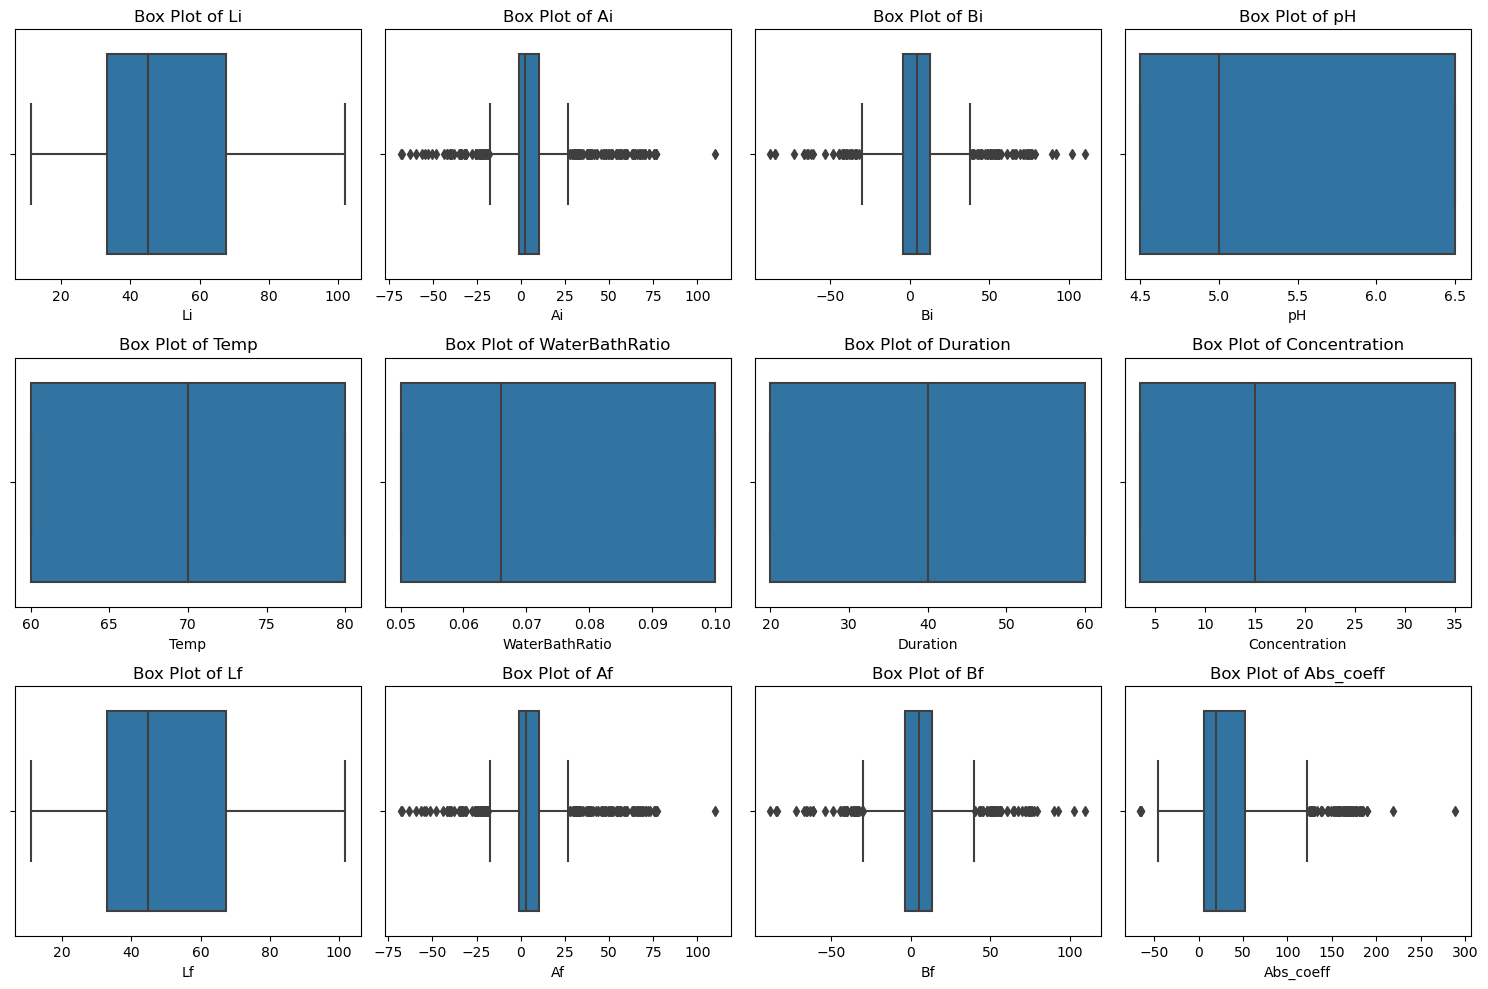

In [20]:
numfeatures = ['Li', 'Ai', 'Bi', 'pH', 'Temp', 'WaterBathRatio', 'Duration', 'Concentration', 'Lf', 'Af', 'Bf','Abs_coeff']

plt.figure(figsize=(15, 10))
for feature in numfeatures:
    plt.subplot(3, 4, numfeatures.index(feature) + 1)
    sns.boxplot(x=df[feature])
    plt.title("Box Plot of " + feature)
plt.tight_layout()
plt.show()

In [21]:
df.isnull().sum()

Color             0
Li                0
Ai                0
Bi                0
Concentration     6
pH                0
Temp              0
WaterBathRatio    0
Duration          0
DyeingMethod      0
Lf                0
Af                0
Bf                0
Thickness         0
Thread            0
thread_group      1
Substrate         0
R                 0
G                 0
B                 0
Hex_code          0
Abs_coeff         0
dtype: int64

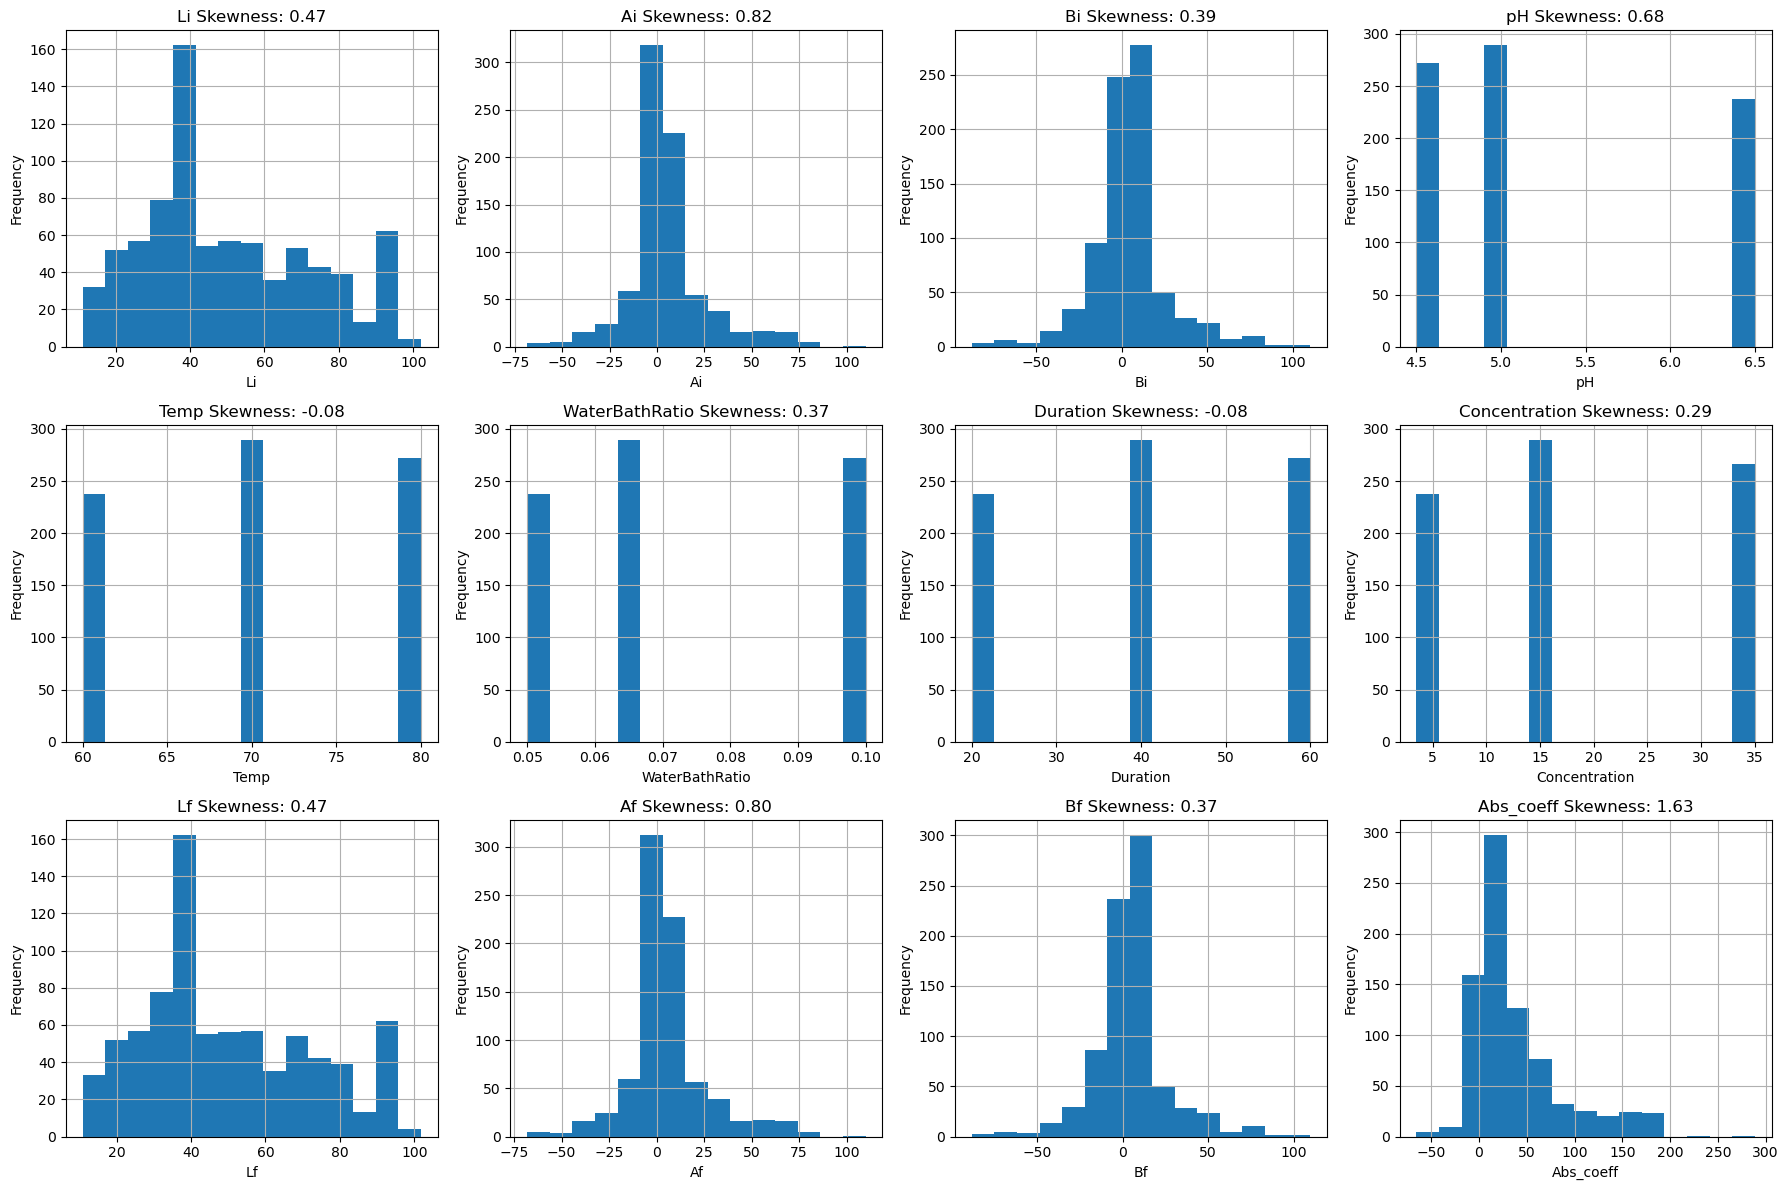

In [22]:
#numfeatures = ['Li', 'Ai', 'Bi', 'pH', 'Temp', 'BathRatio', 'Duration', 'Concentration', 'Lf', 'Af', 'Bf']

# Calculate skewness for each numerical column
skewness = df[numfeatures].skew()

# Plot histograms for each numerical column
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 12))
for i, column in enumerate(numfeatures):
    ax = axes[i // 4, i % 4]
    df[column].hist(ax=ax, bins=15)
    ax.set_title(f"{column} Skewness: {skewness[column]:.2f}")
    ax.set_xlabel(column)
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [23]:
col_mean = ['Li','Bi', 'Temp','Duration','Lf','Bf']
col_median = [ 'pH','Ai', 'WaterBathRatio',  'Concentration',  'Af','Abs_coeff']

# Fill missing values with column-wise mean
df[col_mean] = df[col_mean].fillna(df[col_mean].mean())

# Fill missing values with column-wise median
df[col_median] = df[col_median].fillna(df[col_median].median())

In [24]:
df.columns

Index(['Color', 'Li', 'Ai', 'Bi', 'Concentration', 'pH', 'Temp',
       'WaterBathRatio', 'Duration', 'DyeingMethod', 'Lf', 'Af', 'Bf',
       'Thickness', 'Thread', 'thread_group', 'Substrate ', 'R', 'G', 'B',
       'Hex_code', 'Abs_coeff'],
      dtype='object')

In [25]:
col_mode = ['thread_group', 'Substrate ','Thread','DyeingMethod']

df[col_mode] = df[col_mode].fillna(df[col_mode].mode())


In [26]:
df.isnull().sum()

Color             0
Li                0
Ai                0
Bi                0
Concentration     0
pH                0
Temp              0
WaterBathRatio    0
Duration          0
DyeingMethod      0
Lf                0
Af                0
Bf                0
Thickness         0
Thread            0
thread_group      1
Substrate         0
R                 0
G                 0
B                 0
Hex_code          0
Abs_coeff         0
dtype: int64

In [27]:
df.drop(df[(df['Li'] > 100)  & (df['Li'] < 0)].index, inplace=True)
df.drop(df[(df['Lf'] > 100) & (df['Li'] < 0)].index, inplace=True)

In [28]:
#df.to_excel("data_with_rgb.xlsx", index=False)

In [29]:
df

,Color,Li,Ai,Bi,Concentration,pH,Temp,WaterBathRatio,Duration,DyeingMethod,...,Bf,Thickness,Thread,thread_group,Substrate,R,G,B,Hex_code,Abs_coeff
0,L.Yellow,89.0000,-7.6000,35.700,15.0,5.0,70,0.066,40,POM with CuSo4,...,36.380,0.025,Single Fibre,TRP,Cotton,227.970855,226.773715,154.184169,#e4e39a,90.888966
1,565E79,40.1900,3.6000,-16.220,3.5,6.5,60,0.050,20,Directly dyed without mordant,...,-16.920,0.127,Coarse,TRP,Cotton,89.902612,93.485534,121.202297,#5a5d79,3.012377
2,N13,66.6100,-13.6320,-33.780,3.5,6.5,60,0.050,20,Directly dyed without mordant,...,-34.480,0.025,Single Fibre,TRP,Cotton,93.183117,171.097178,222.283291,#5dabde,-2.988177
3,N18,32.1121,54.3505,-84.823,15.0,5.0,70,0.066,40,POM with CuSo4,...,-84.143,0.127,Coarse,TRP,Cotton,79.432651,36.004754,214.792358,#4f24d7,5.399206
4,N10,32.6300,-25.4630,1.953,35.0,4.5,80,0.100,60,SM with CuSo4,...,1.333,0.025,Single Fibre,CFP-MEDIUM,Cotton,13.033237,87.272098,72.762571,#0d5749,-65.409390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,S496,84.0300,1.4300,0.310,3.5,6.5,60,0.050,20,Directly dyed without mordant,...,0.990,0.076,Coarse,FENGSHU-F,Linen,212.521581,208.634104,208.997881,#d5d1d1,23.776020
795,S497,40.7400,-4.5400,-33.910,3.5,6.5,60,0.050,20,Directly dyed without mordant,...,-33.230,0.015,Single Fibre,PPC-TJNM-F,Linen,47.843939,100.106475,151.612333,#306498,-30.257899
796,S498,49.6200,-7.7600,-29.950,15.0,4.5,80,0.100,60,SM with CuSo4,...,-29.270,0.076,Coarse,PPC-TJNM-F,Linen,70.576416,123.501026,168.603433,#477ca9,-2.218845
797,S499,40.9300,-4.3400,-34.100,3.5,6.5,60,0.050,20,Directly dyed without mordant,...,-33.420,0.015,Single Fibre,PPC-TJNM-F,Linen,48.712233,100.484722,152.438128,#316498,-29.147668


## Feature Extraction

In [30]:
# Function to convert LAB values to Hex code
#Lab -> RGB -> hexCode

def hex_to_rgb(hex_code):
    hex_code = hex_code.lstrip('#')
    return tuple(int(hex_code[i:i+2], 16) for i in (0, 2, 4))

#Hexcode to RGB, image using RGB
def create_color_image(hex_code, width=100, height=100):
    rgb = hex_to_rgb(hex_code)
    image = Image.new('RGB', (width, height), rgb)
    return image

def ttype(thread):
    if thread == 'Single Fibre' or 'singlefibre':
        return 0.025
    elif thread == 'Coarse' or 'coarse':
        return 0.127

In [31]:
#https://python-colormath.readthedocs.io/en/latest/_modules/colormath/color_diff.html#delta_e_cie1976
def _get_lab_color1(color):
    if not color.__class__.__name__ == 'LabColor':
        raise ValueError("Delta E functions can only be used with two LabColor objects.")
    return np.array([color.lab_l, color.lab_a, color.lab_b])

def _get_lab_color2(color):
    if not color.__class__.__name__ == 'LabColor':
        raise ValueError("Delta E functions can only be used with two LabColor objects.")
    return np.array([(color.lab_l, color.lab_a, color.lab_b)])

def delta_e_cie1976(color1, color2):
    color1 = _get_lab_color1(color1)
    color2 = _get_lab_color2(color2)
    delta_e = color_diff_matrix.delta_e_cie1976(color1, color2)
    return np.float64(delta_e)

def color(L,A,B):
    color = LabColor(lab_l=L, lab_a=A, lab_b=B)
    return color
#color2 = LabColor(lab_l=L, lab_a=A, lab_b=B)

In [32]:
df.columns

Index(['Color', 'Li', 'Ai', 'Bi', 'Concentration', 'pH', 'Temp',
       'WaterBathRatio', 'Duration', 'DyeingMethod', 'Lf', 'Af', 'Bf',
       'Thickness', 'Thread', 'thread_group', 'Substrate ', 'R', 'G', 'B',
       'Hex_code', 'Abs_coeff'],
      dtype='object')

## Data

In [33]:
df.columns

Index(['Color', 'Li', 'Ai', 'Bi', 'Concentration', 'pH', 'Temp',
       'WaterBathRatio', 'Duration', 'DyeingMethod', 'Lf', 'Af', 'Bf',
       'Thickness', 'Thread', 'thread_group', 'Substrate ', 'R', 'G', 'B',
       'Hex_code', 'Abs_coeff'],
      dtype='object')

In [34]:
from sklearn.preprocessing import LabelEncoder

# Create LabelEncoder instances for 'DyeingMethod' and 'Thread'
DyeingMethod_encoder = LabelEncoder()
Thread_encoder = LabelEncoder()
thread_group_encoder = LabelEncoder()
Substrate_encoder = LabelEncoder()

# Encode the 'DyeingMethod' and 'Thread' columns in place
df['DyeingMethod'] = DyeingMethod_encoder.fit_transform(df['DyeingMethod'])
df['Thread'] = Thread_encoder.fit_transform(df['Thread'])
df['thread_group'] = thread_group_encoder.fit_transform(df['thread_group'])
df['Substrate '] = Substrate_encoder.fit_transform(df["Substrate "])

# Define a list of columns and their corresponding encoders for printing
columns_and_encoders = [
    ('DyeingMethod', DyeingMethod_encoder),
    ('Thread', Thread_encoder),
    ('thread_group',thread_group_encoder),
    ('Substrate ',Substrate_encoder)
]

# Iterate through the columns and encoders and print the mapping
for column, encoder in columns_and_encoders:
    encoded_values = df[column].unique()
    print(f"Column: {column}")
    for encoded in encoded_values:
        decoded_value = encoder.inverse_transform([encoded])[0]
        print(f"Encoded: {encoded}, Decoded: {decoded_value}")
    print("\n")


Column: DyeingMethod
Encoded: 1, Decoded: POM with CuSo4
Encoded: 0, Decoded: Directly dyed without mordant
Encoded: 2, Decoded: SM with CuSo4


Column: Thread
Encoded: 1, Decoded: Single Fibre
Encoded: 0, Decoded: Coarse


Column: thread_group
Encoded: 40, Decoded: TRP
Encoded: 7, Decoded: CFP-MEDIUM
Encoded: 5, Decoded: CFP-COR-A
Encoded: 4, Decoded: BRP_FINE
Encoded: 3, Decoded: BRP_COARSE
Encoded: 6, Decoded: CFP-COR-D
Encoded: 13, Decoded: DURA_MICRO
Encoded: 17, Decoded: GRAL
Encoded: 23, Decoded: IBN_MEDIUM
Encoded: 22, Decoded: IBN_CORSER
Encoded: 28, Decoded: PPC-TJNM-F
Encoded: 27, Decoded: PPC ZHON FINE
Encoded: 44, Decoded: TXP_M_THAIMAN
Encoded: 32, Decoded: RPC_FINE
Encoded: 19, Decoded: IBN FINE
Encoded: 45, Decoded: nan
Encoded: 20, Decoded: IBN MEDIUM
Encoded: 41, Decoded: TXN_TAHILON
Encoded: 24, Decoded: MFP
Encoded: 36, Decoded: SSA FINE
Encoded: 14, Decoded: FENGSH-F
Encoded: 39, Decoded: SSP_V_FINE
Encoded: 35, Decoded: SSA COR-B
Encoded: 38, Decoded: SSP-FENGSHU-

In [35]:
df.columns

Index(['Color', 'Li', 'Ai', 'Bi', 'Concentration', 'pH', 'Temp',
       'WaterBathRatio', 'Duration', 'DyeingMethod', 'Lf', 'Af', 'Bf',
       'Thickness', 'Thread', 'thread_group', 'Substrate ', 'R', 'G', 'B',
       'Hex_code', 'Abs_coeff'],
      dtype='object')

## RANSAC

In [36]:
X = df[['Li', 'Ai', 'Bi', 'Concentration', 'pH', 'Temp', 'WaterBathRatio', 'DyeingMethod', 'Duration', 'Substrate ','Thread','Thickness','thread_group','Abs_coeff']]
Y = df[['Lf', 'Af', 'Bf']]

In [37]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.3, random_state=42)

# RANSAC Regression
ransac = RANSACRegressor(min_samples=100, max_trials=80,loss='squared_error', random_state=40,residual_threshold=10)
ransac.fit(X_train, Y_train)
ransac_pred = ransac.predict(X_test)
ransac_mse = mean_squared_error(Y_test, ransac_pred)
print("RANSAC Regression MSE:", ransac_mse)

RANSAC Regression MSE: 0.06116174999549287


In [38]:
# Calculate the R-squared score to measure accuracy
r2 = r2_score(Y_test, ransac_pred)
print("R-squared:", r2)

R-squared: 0.9998725195767171


Enter Initial Shade:	6,36,96
Enter concentration of the shade:	15
Enter pH:	5
Enter Temperature:	70
Enter WaterBathRatio:	0.01
Enter Duration:	60
Enter DyeingMethod:	SM with CuSo4
Enter the Substrate:	Cotton
Enter the type of thread:	Coarse
Enter the thread group:	IBN MEDIUM
L: 5.635122250609541, A: 35.80836836800535, B: 95.840662483542

Predicted Shade


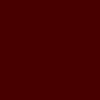

In [ ]:
I_Shade = input("Enter Initial Shade:\t")
Li, Ai, Bi = I_Shade.split(",")[:3]
R,G,B = lab_to_rgb(Li, Ai, Bi)
Concentration = input("Enter concentration of the shade:\t")
pH = input("Enter pH:\t")
Temp = input("Enter Temperature:\t")
WaterBathRatio = input("Enter WaterBathRatio:\t")
Duration = input("Enter Duration:\t")
DyeingMethod = input("Enter DyeingMethod:\t")
Substrate = input("Enter the Substrate:\t")
Thread = input("Enter the type of thread:\t")
Thickness = ttype(Thread)
thread_group = input("Enter the thread group:\t")
Abs_coeff = create_abs_coeff(Thickness, R,G,B)
ran_prediction = ransac.predict([[float(Li),float(Ai), float(Bi), float(Concentration), float(pH), int(Temp), float(WaterBathRatio), int(DyeingMethod_encoder.transform([DyeingMethod])),int(Duration),
                             int(Substrate_encoder.transform([Substrate])),int(Thread_encoder.transform([Thread])), float(Thickness), int(thread_group_encoder.transform([thread_group])),float(Abs_coeff)]])
L, A, B = ran_prediction[0]
color2 = color(L, A, B)
color1 = color(Li, Ai, Bi)
print(f'L: {L}, A: {A}, B: {B}\n')
hex_code = lab_to_hex(L, A, B)
image = create_color_image(hex_code)
print("Predicted Shade")
image


Color Difference 0.4418675124199364


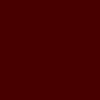

In [ ]:
delta_e = delta_e_cie1976(color1, color2)
print(f"Color Difference {delta_e}")

hex_code = lab_to_hex(Li, Ai, Bi)
image = create_color_image(hex_code)
image

In [39]:
import joblib

In [40]:
from joblib import dump

In [41]:
dump(ransac,'C:/Users/HP/djlab/savedModels/RANSAC.joblib')

['C:/Users/HP/djlab/savedModels/RANSAC.joblib']